<a href="https://colab.research.google.com/github/AeroEng16/machine-learning-with-python-logistic-regression-3211129/blob/main/02_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np


In [37]:
!pip install torchmetrics
import torchmetrics

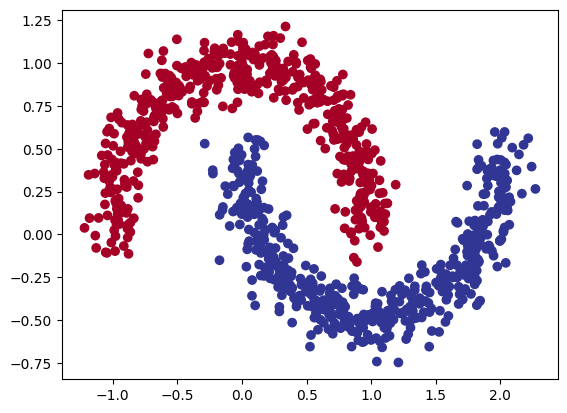

In [38]:
#Data creation hyperparameters

n_samples = 1000
noise = 0.1

X_moon,Y_moon = make_moons(n_samples = n_samples, noise = noise, random_state=42)

plt.scatter(X_moon[:,0],X_moon[:,1],c=Y_moon,cmap = plt.cm.RdYlBu)


In [39]:
#Device agnostic

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [40]:
# Train/test split

X_moon_train,X_moon_test,Y_moon_train,Y_moon_test = train_test_split(X_moon,Y_moon,test_size=0.2)
X_moon_train = torch.from_numpy(X_moon_train).type(torch.float)
Y_moon_train = torch.from_numpy(Y_moon_train).type(torch.float)
X_moon_test = torch.from_numpy(X_moon_test).type(torch.float)
Y_moon_test = torch.from_numpy(Y_moon_test).type(torch.float)

In [41]:
class MoonClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linearStack = torch.nn.Sequential(
        torch.nn.Linear(in_features = 2, out_features = 10),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 10, out_features = 10),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 10, out_features = 1)
    )

  def forward(self,x):
    return self.linearStack(x)



In [42]:
moonModel = MoonClassificationModel()
moonModel.to(device)

MoonClassificationModel(
  (linearStack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [50]:
# Loss function and optimiser

loss_fn = nn.BCEWithLogitsLoss()

optimiser = torch.optim.SGD(params = moonModel.parameters(),
                            lr = 0.1)

acc_fn = torchmetrics.Accuracy(task="binary")

In [51]:
# Train and Test

epochs = 1000
X_moon_train = X_moon_train.to(device)
y_moon_train = Y_moon_train.to(device)
X_moon_test = X_moon_test.to(device)
y_moon_test = Y_moon_test.to(device)
for epoch in range(epochs):
  moonModel.train()
  # 1. Forward pass
  y_logits = moonModel(X_moon_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  # 2. Loss Calc
  loss = loss_fn(y_logits,Y_moon_train)
  acc = acc_fn(y_preds,Y_moon_train)
  # 3. Zero grad
  optimiser.zero_grad()
  # 4. Back Propagate
  loss.backward()
  # 5. Optimiser Step
  optimiser.step()
  # 6. Evaluate
  moonModel.eval()
  with torch.inference_mode():
    test_logits = moonModel(X_moon_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_preds,Y_moon_test)
    test_acc = acc_fn(test_preds,Y_moon_test)
  if epoch%50 == 0:
    print(f"Epoch: {epoch}, Loss: {loss}, Acc: {acc}, Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 0, Loss: 0.17310304939746857, Acc: 0.9225000143051147, Test Loss: 0.5313049554824829, Test Acc: 0.9300000071525574
Epoch: 50, Loss: 0.1536763310432434, Acc: 0.9350000023841858, Test Loss: 0.5294055342674255, Test Acc: 0.9350000023841858
Epoch: 100, Loss: 0.13228027522563934, Acc: 0.9437500238418579, Test Loss: 0.5275061130523682, Test Acc: 0.9399999976158142
Epoch: 150, Loss: 0.11097244918346405, Acc: 0.9599999785423279, Test Loss: 0.5163050293922424, Test Acc: 0.9599999785423279
Epoch: 200, Loss: 0.09174049645662308, Acc: 0.9662500023841858, Test Loss: 0.5044056177139282, Test Acc: 0.9850000143051147
Epoch: 250, Loss: 0.07581755518913269, Acc: 0.9775000214576721, Test Loss: 0.5044056177139282, Test Acc: 0.9850000143051147
Epoch: 300, Loss: 0.06332091242074966, Acc: 0.9850000143051147, Test Loss: 0.4994055926799774, Test Acc: 0.9950000047683716
Epoch: 350, Loss: 0.05360608175396919, Acc: 0.9887499809265137, Test Loss: 0.4994055926799774, Test Acc: 0.9950000047683716
Epoch: 400, 

In [48]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

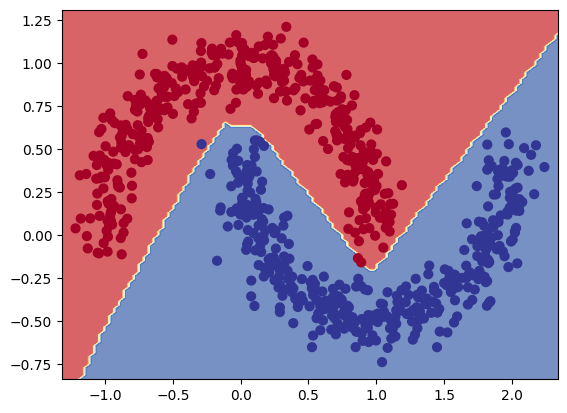

In [52]:
plot_decision_boundary(moonModel,X_moon_train,Y_moon_train)

## Replicate Tanh

In [54]:
A = torch.arange(-10,10,1,dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [ ]:
def Tanh(x):
  return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

plt.plot(Tanh(A))

## Create a Spiral Multiclass dataset

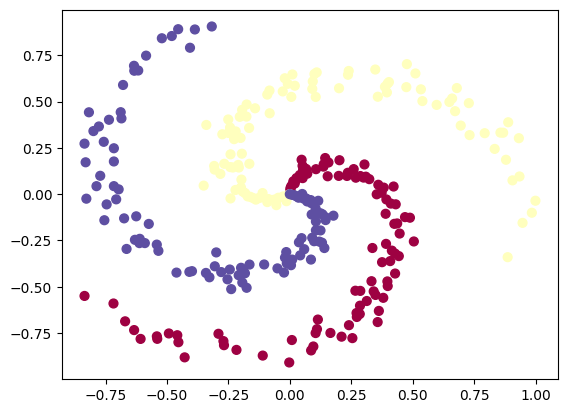

In [56]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [77]:
class SpiralClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linearStack = torch.nn.Sequential(
        torch.nn.Linear(in_features = 2, out_features = 10),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 10, out_features = 10),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 10, out_features = 3)
    )

  def forward(self,x):
    return self.linearStack(x)

In [78]:
spiralModel = SpiralClassificationModel()
spiralModel.to(device)


SpiralClassificationModel(
  (linearStack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [79]:
# Train/test split

X_spiral_train,X_spiral_test,Y_spiral_train,Y_spiral_test = train_test_split(X,y,test_size=0.2)
X_spiral_train = torch.from_numpy(X_spiral_train).type(torch.float)
Y_spiral_train = torch.from_numpy(Y_spiral_train).type(torch.float)
X_spiral_test = torch.from_numpy(X_spiral_test).type(torch.float)
Y_spiral_test = torch.from_numpy(Y_spiral_test).type(torch.float)

In [80]:
# Loss function and optimiser

loss_fn = nn.CrossEntropyLoss()

optimiser = torch.optim.SGD(params = spiralModel.parameters(),
                            lr = 0.1)

acc_fn = torchmetrics.Accuracy(task="multiclass",num_classes=3)

In [81]:
X_spiral_train = X_spiral_train.to(device)
y_spiral_train = Y_spiral_train.to(device)
X_spiral_test = X_spiral_test.to(device)
y_spiral_test = Y_spiral_test.to(device)

torch.unique(y_spiral_train)

tensor([0., 1., 2.])

In [84]:
# Train and Test

epochs = 4000

for epoch in range(epochs):
  spiralModel.train()
  # 1. Forward pass
  y_logits = spiralModel(X_spiral_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
  # 2. Loss Calc
  loss = loss_fn(y_logits,y_spiral_train.type(torch.LongTensor))
  acc = acc_fn(y_preds,y_spiral_train)
  # 3. Zero grad
  optimiser.zero_grad()
  # 4. Back Propagate
  loss.backward()
  # 5. Optimiser Step
  optimiser.step()
  # 6. Evaluate
  moonModel.eval()
  with torch.inference_mode():
    test_logits = spiralModel(X_spiral_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_preds,y_spiral_test.type(torch.LongTensor))
    test_acc = acc_fn(test_preds,y_spiral_test)
  if epoch%200 == 0:
    print(f"Epoch: {epoch}, Loss: {loss}, Acc: {acc}, Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 0, Loss: 0.41782382130622864, Acc: 0.8083333373069763, Test Loss: 0.7940897345542908, Test Acc: 0.699999988079071
Epoch: 200, Loss: 0.40053126215934753, Acc: 0.887499988079071, Test Loss: 0.8044413924217224, Test Acc: 0.6499999761581421
Epoch: 400, Loss: 0.2795836627483368, Acc: 0.8833333253860474, Test Loss: 0.7762839794158936, Test Acc: 0.7333333492279053
Epoch: 600, Loss: 0.21354255080223083, Acc: 0.9166666865348816, Test Loss: 0.7348772883415222, Test Acc: 0.800000011920929
Epoch: 800, Loss: 0.1858104020357132, Acc: 0.9416666626930237, Test Loss: 0.7348772883415222, Test Acc: 0.800000011920929
Epoch: 1000, Loss: 0.2188446819782257, Acc: 0.9333333373069763, Test Loss: 0.7555806040763855, Test Acc: 0.7833333611488342
Epoch: 1200, Loss: 0.1397523432970047, Acc: 0.9541666507720947, Test Loss: 0.7285622358322144, Test Acc: 0.800000011920929
Epoch: 1400, Loss: 0.13573148846626282, Acc: 0.9583333134651184, Test Loss: 0.7337380647659302, Test Acc: 0.7666666507720947
Epoch: 1600, Los

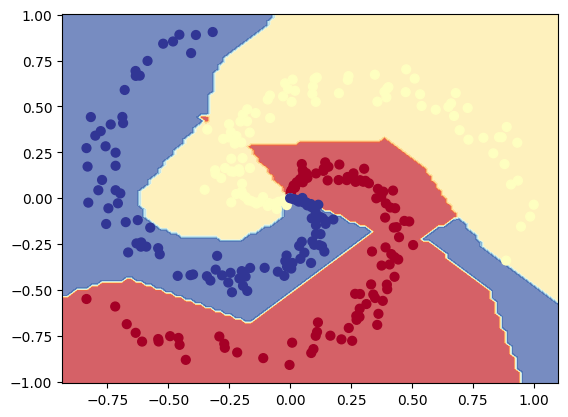

In [87]:
plot_decision_boundary(spiralModel,torch.from_numpy(X).type(torch.float),torch.from_numpy(y).type(torch.float))